Installing *yt-dlp* to download the image frame from the YouTube videos and *pyarrow* 

In [1]:
!pip install yt-dlp
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 KB 23.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing all the useful packages

In [2]:
import yt_dlp
import os
#from tqdm import tqdm 
from tqdm.notebook import tqdm
import cv2
import shutil
import time
import random
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
from datetime import timedelta

from google.colab import widgets

In [3]:
# Importing drive to download or update datasets
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Setting Up Dataset


In [4]:
# Hyperparameters

percentage_train_test = 10
percentage_bag_shots = 1
percentage_to_ignore = 10

zip_f_name = f'VideoClassificationDataset_{percentage_train_test}_{percentage_bag_shots}_{percentage_to_ignore}'
drive_dataset_folder = f'/content/drive/MyDrive/Datasets_VideoClassification/{zip_f_name}'

##Download frames

In [ ]:
dataset_path = Path('/content/VideoClassificationDataset')

# Download the .zip file
!wget --no-verbose https://github.com/gtoderici/sports-1m-dataset/archive/refs/heads/master.zip

# Extract it 
!unzip -qq -o '/content/master.zip' 
!rm '/content/master.zip

In [ ]:
DATA = {'train_partition.txt': {},
        'test_partition.txt': {}}

LABELS = []

train_dict = {}
test_dict = {}

path = '/content/sports-1m-dataset-master/original'

# Populate the DATA dictionary by reading the train and test files
for f in os.listdir(path):
    with open(path + '/' + f) as f_txt:
        lines = f_txt.readlines()
        for line in lines:
            splitted_line = line.split(' ')
            label_indices = splitted_line[1].rstrip('\n').split(',') 

            # Throw away the url with multiple urls
            #if(len(label_indices) == 1):
                #DATA[f][splitted_line[0]] = str(label_indices[0])
            
            DATA[f][splitted_line[0]] = list(map(int, label_indices))

# Obtain the labels from the relative .txt file
with open('/content/sports-1m-dataset-master/labels.txt') as f_labels:
    LABELS = f_labels.read().splitlines()

In [ ]:
TRAIN = DATA['train_partition.txt']
TEST = DATA['test_partition.txt']
print('Original Train Test length: ', len(TRAIN), len(TEST))

# Sample a subset of percentage_train_test
TRAIN = dict(random.sample(list(TRAIN.items()), (len(TRAIN)*percentage_train_test)//100))
TEST = dict(random.sample(list(TEST.items()), (len(TEST)*percentage_train_test)//100))

print(f'Sampled {percentage_train_test} % of Train & Test datasets, updated length: ', len(TRAIN), len(TEST))

if not os.path.exists(dataset_path): os.makedirs(dataset_path)
if not os.path.exists(f'{dataset_path}/train'): os.makedirs(f'{dataset_path}/train')
if not os.path.exists(f'{dataset_path}/test'): os.makedirs(f'{dataset_path}/test')

Original Train Test length:  914491 218667
Sampled 10 % of Train & Test datasets, updated length:  91449 21866


In [ ]:
'''
PORPOUSE: Extract frames from a given youtube video

TAKES:
  - capture: cv2.VideoCapture(url) variable, with url being the link to the video
  - directory: describe the saving directory
  - idx_bag: indicate the index of the actual bag of shots
  - start_frame: indicates the starting frame
  - end_frame: indicates the ending frame

RETURNS:
  True or False depending the presence of errors
'''

def extract_frames(capture, directory, idx_bag, start_frame, end_frame):
    count = start_frame

    # Set the next frame to download to 'count'
    capture.set(cv2.CAP_PROP_POS_FRAMES, count)
    os.makedirs(f'{directory}/bag_of_shots{str(idx_bag)}') # Create the relative directory

    # Download the frame until we do not reach the end_frame
    while count < end_frame:

        ret, frame = capture.read() # Read the frame

        if not ret: # In case there are errors, delete the aforementioned directory of bag of shots
            shutil.rmtree(f'{directory}/bag_of_shots{str(idx_bag)}')
            return False

        # Save the readed frame in the directory of bag of shots resizing it to be 178x178
        filename = f'{directory}/bag_of_shots{str(idx_bag)}/shot{str(count - start_frame)}.png'
        write_res = cv2.imwrite(filename, cv2.resize(frame, (178, 178), interpolation = cv2.INTER_AREA))
        if write_res:
            count += 1    # If there is no error I increment the count
        else:   # Otherwise I delete the all bag of shots returning Falses
            shutil.rmtree(f'{directory}/bag_of_shots{str(idx_bag)}')
            return False

    return True

In [ ]:
'''
PORPOUSE: Determine the amount of frame and bag of shots we want to downloads in each video, and perform the download of them

TAKES:
  - video_url: complete url link to a specific YouTubbe video
  - labels_list: list of indices labels of the relative video

  - label_id: index label of the relative video

  - idx_bag: indicate the index of the actual bag of shots
  - percentage_of_bags: indicate the percentage of bags of shots that we want to download

RETURNS: 
  ret_dictionary: A dictionary containing as keys the path to a specific bag of shots and as value the list of labels for the 
                  relative bag, the last element of this list represent the number of frames we have downloaded
'''

def video_to_frames(video_url, labels_list, directory, percentage_of_bags): # labels_list
    url_id = video_url.split('=')[1]
    path_until_url_id = f'{dataset_path}/{directory}/{url_id}'
    
    ret_dictionary = {}

    try:   

        # Setting up the dictionary options for yd-dlp
        ydl_opts = {
            'ignoreerrors': True,
            'quiet': True,
            'nowarnings': True,
            'ignorenoformatserror': True,
            'verbose':False,
            'cookies': '/content/all_cookies.txt',
            #https://stackoverflow.com/questions/63329412/how-can-i-solve-this-youtube-dl-429
        }
        ydl = yt_dlp.YoutubeDL(ydl_opts)
        info_dict = ydl.extract_info(video_url, download=False) # Extracting the video infromation

        if(info_dict is not None and  info_dict['fps'] >= 20):
            # I must have a least 20 frames per seconds since I take half of second bag of shots for every video

            formats = info_dict.get('formats', None)

            # Excluding the initial and final choosen percentage of each video to avoid noise
            video_length = info_dict['duration'] * info_dict['fps']

            shots = info_dict['fps'] // 2

            to_ignore = (video_length * percentage_to_ignore) // 100
            new_len = video_length - (to_ignore * 2)
            tot_stored_bags = ((new_len // shots) * percentage_of_bags) // 100   # ((total_possbile_bags // shots) * percentage_of_bags) // 100

            if tot_stored_bags == 0: tot_stored_bags = 1 # I take at least a bag of shots

            # Computing the skip rate between bags
            skip_rate_between_bags = (new_len - (tot_stored_bags * shots)) // (tot_stored_bags-1) if tot_stored_bags > 1 else 0

            chunks = [[to_ignore+(bag*(skip_rate_between_bags+shots)), to_ignore+(bag*(skip_rate_between_bags+shots))+shots] for bag in range(tot_stored_bags)]
            # Sequence of [[start_frame, end_frame], [start_frame, end_frame], [start_frame, end_frame], ...]

            format_id = {}
            for f in formats: format_id[f['format_id']] = f

            if '160' in list(format_id.keys()): # The downlaod is applyed only if the 144p format is available, 160 is the format_id for 144p
                video = format_id['160']
                url = video.get('url', None)
                if(video.get('url', None) != video.get('manifest_url', None)): # We move forward only in case the url is different from the manifest_url

                    if not os.path.exists(path_until_url_id): os.makedirs(path_until_url_id)
                    
                    capture = cv2.VideoCapture(url) # Initialize VideoCapture variable
                    valid_chunks = 0

                    for idx_bag, f in enumerate(chunks): # For each chunks

                        # In case the download of the bag of shots succedeed
                        if(extract_frames(capture, path_until_url_id, idx_bag, f[0], f[1])):
                          
                            l = np.zeros(len(LABELS), dtype=int) 
                            for label in labels_list: l[label] = 1 # np.array of labels indices
                            l = np.append(l, [shots]) # Appending as last element the number of downloaded frames

                            '''l = np.array([label_id, shots])
                            valid_chunks += 1'''

                            ret_dictionary[f'{directory}/{url_id}/bag_of_shots{str(idx_bag)}'] = l.tolist() # Populate the new dictionary row

                    # In case we do not have downloaded any chunks delete the directory and all its content
                    if valid_chunks == 0: shutil.rmtree(path_until_url_id)

                    capture.release()

        return ret_dictionary


    except Exception as e:
        # If an exception rised delete the directory with all its content and return ret_dictionary
        if os.path.exists(path_until_url_id): shutil.rmtree(path_until_url_id)
        return ret_dictionary


In [ ]:
start_time = time.time()

count = 0

# Perform a parallel download
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as pool:
    with tqdm(total = len(TRAIN.items()), leave=False, desc='Downloading Train Dataset') as progress: # Setting up the progress bar
        
        futures = [] # Array of features

        for url, labels_list in TRAIN.items():
            future = pool.submit(video_to_frames, url, labels_list, 'train', percentage_bag_shots) # Assign the download
            future.add_done_callback(lambda p: progress.update()) # Update the progrress bar
            futures.append(future) # Append the feature to the features array

        for future in futures:
            if len(future.result()) > 0: # In case the result of the featue is not empty
                train_dict.update(future.result()) # Append the result to the final dictionaty
                count += 1


print(f'--- Downloaded {count} videos frames in {(timedelta(seconds=(time.time() - start_time)))} (H:M:S:ms) ---')

In [ ]:
start_time = time.time()

count = 0

# Perform a parallel download
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as pool:
    with tqdm(total = len(TEST.items()), leave=False, desc='Downloading Test Dataset') as progress: # Setting up the progress bar
        
        futures = [] # Array of features

        for url, labels_list in TEST.items():
            future = pool.submit(video_to_frames, url, labels_list, 'test', percentage_bag_shots) # Assign the download
            future.add_done_callback(lambda p: progress.update()) # Update the progrress bar
            futures.append(future) # Append the feature to the features array

        for future in futures:
            if len(future.result()) > 0: # In case the result of the featue is not empty
                test_dict.update(future.result()) # Append the result to the final dictionaty
                count += 1


print(f'--- Downloaded {count} videos frames in {(timedelta(seconds=(time.time() - start_time)))} (H:M:S:ms) ---')

## Save CSV and upload file Zip

In [ ]:
# Convert the dictionary to pandas DataFrame resetting the index
train_df = pd.DataFrame.from_dict(train_dict, orient='index', dtype=int).reset_index(level=0)
train_df = train_df.rename(columns={train_df.columns[-1]: 'shots'}) # Rename the last column as 'shots'
train_df.columns = train_df.columns.astype(str) # Setting the column type as string
train_df.to_parquet(f'{dataset_path}/train.parquet', index=True) # Generation the parquet file

# Convert the dictionary to pandas DataFrame resetting the index
test_df = pd.DataFrame.from_dict(test_dict, orient='index', dtype=int).reset_index(level=0)
test_df = test_df.rename(columns={test_df.columns[-1]: 'shots'}) # Rename the last column as 'shots'
test_df.columns = test_df.columns.astype(str) # Setting the column type as string
test_df.to_parquet(f'{dataset_path}/test.parquet', index=True) # Generation the parquet file

In [ ]:
shutil.make_archive('train', 'zip', f'{dataset_path}/train') # Create a train.zip file
shutil.make_archive('test', 'zip', f'{dataset_path}/test') # Create a test.zip file
os.mkdir(drive_dataset_folder) # Create remote drive folder

# Coping the .zip, .parquet and .txt file into the remote directory
shutil.copyfile('/content/sports-1m-dataset-master/labels.txt', drive_dataset_folder)
shutil.copyfile(f'{dataset_path}/train.parquet', drive_dataset_folder)
shutil.copyfile(f'{dataset_path}/test.parquet', drive_dataset_folder)
shutil.copyfile(f'{dataset_path}/train.zip', drive_dataset_folder)
shutil.copyfile(f'{dataset_path}/test.zip', drive_dataset_folder)

## Downloadload Dataset from Google Drive

In [5]:
# With ZipFile I also download the .zip and at the same time unzipping it so I need the double capacity

dataset_path = Path('/content/VideoClassificationDataset')

# Unzip the train and test zip files in Colab Storage
for z in ['train', 'test']:
    with zipfile.ZipFile(f'{drive_dataset_folder}/{z}.zip', 'r') as zip_ref:
        for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc=f'Unzipping {z}.zip'):
            zip_ref.extract(member=file, path=dataset_path)

# Copy the train and test .parquet and labels.txt in Colab Storage
shutil.copy(f'{drive_dataset_folder}/train.parquet', dataset_path)
shutil.copy(f'{drive_dataset_folder}/test.parquet', dataset_path)
shutil.copy(f'{drive_dataset_folder}/labels.txt', dataset_path)

print('All done')

Unzipping train.zip:   0%|          | 0/1592774 [00:00<?, ?it/s]

Unzipping test.zip:   0%|          | 0/353812 [00:00<?, ?it/s]

All done


### Read labels.txt, train.parquet and test.parquet

In [6]:
LABELS = []

train_dict = {}
test_dict = {}

# Obtain the list of labels
with open(f'{dataset_path}/labels.txt') as f_labels:
    LABELS = f_labels.read().splitlines()

train_df = pd.read_parquet(f'{dataset_path}/train.parquet') # Read the parquet train dataset
test_df = pd.read_parquet(f'{dataset_path}/test.parquet') # Read the parquet test dataset


'''for k,v in tqdm(train_df.T.items(), total=len(list(train_df.T.items())), desc='Populating train dictionary'):
    values = v.to_numpy()
    train_dict[values[0]] = list(values[1:]) # Populate the train dictionary

for k,v in tqdm(test_df.T.items(), total=len(list(test_df.T.items())), desc='Populating test dictionary'):
    values = v.to_numpy()
    test_dict[values[0]] = list(values[1:]) # Populate the test dictionary'''

for string, df in zip(('train','test'), (train_df, test_df)):
    for k,v in tqdm(df.T.items(), total=len(list(df.T.items())), desc=f'Populating {string} dictionary'):
        values = v.to_numpy()
        df[values[0]] = list(values[1:]) # Populate the dictionary

print(f'\nSampled {percentage_train_test} % of Train & Test datasets')
print(f'Number of train bags of shots: {len(train_df)}')
print(f'Number of test bags of shots: {len(test_dict)}')

Populating train dictionary:   0%|          | 0/106406 [00:00<?, ?it/s]

Populating test dictionary:   0%|          | 0/22874 [00:00<?, ?it/s]


Sampled 10 % of Train & Test datasets
Number of train bag of shots: 106406
Number of test bag of shots: 22874


# Neural Networks Part

Install the *torchmetrics* package to use the F1-score and *torch_xla* for TPU usage

In [7]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 9.7 MB/s eta 0:00:00


In [8]:
import requests
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from timeit import default_timer as timer 
import copy
from sklearn.metrics import f1_score  

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

from torchmetrics.classification import MultilabelF1Score

torch.autograd.set_detect_anomaly(True)

print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')


PyTorch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device # Setup the device type

'cuda:0'

In [10]:
# Get the train and test path
train_dir = dataset_path / 'train'
test_dir = dataset_path / 'test'

## Initial analysis

In [11]:
'''
PORPOUSE: Obtaining the label name and index of a specific image

TAKES:
  - dictionary: is the dictionary from where we have to extract the ids
  - path: describe the path of the specific bag of shots

RETURNS: Pairs of labels indices and names
'''

def get_label_ids_names(dictionary, path):
    ids = np.where(np.asarray(dictionary[path]) == 1)[0]
    names = [LABELS[id] for id in ids]
    return ids, names

Random image path: /content/VideoClassificationDataset/train/oZZOL-mePk0/bag_of_shots0/shot0.png
Image classes id: ['sepak takraw']
Image classes name: [355]
Image height: 178
Image width: 178


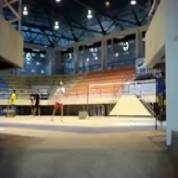

In [12]:
'''
PORPOUSE: Plot a random dataset image with its informations

TAKES:
  - dictionary: is the dictionary from where we have to extract the ids
  - image_path_list: describe the path where we have to sample a image

RETURNS: Pillow image
'''

def plot_random_image(dictionary, image_path_list):
    random_image_path = random.choice(image_path_list) # Sample a image

    path = os.path.relpath(random_image_path.parent, dataset_path) # Get the relative path
    
    image_classes_name, image_classes_id = get_label_ids_names(dictionary, path)
    img = Image.open(random_image_path) # Open the image

    print(f'Random image path: {random_image_path}')
    print(f'Image classes id: {image_classes_id}')
    print(f'Image classes name: {image_classes_name}')
    print(f'Image height: {img.height}') 
    print(f'Image width: {img.width}')

    return img

plot_random_image(train_dict, list(train_dir.glob('*/*/*.png')))

Transforms

In [13]:
# Setting up the train and test transofms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4588,0.4588,0.4588], std=[0.4588,0.4588,0.4588])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4588,0.4588,0.4588], std=[0.4588,0.4588,0.4588])
])

## From Dataset to Dataloader

Dataset creation

In [14]:
# VideoDataset object 

class VideoDataset(Dataset):
    def __init__(self, df, transform = None, t = 'single'):
        self.df = df
        self.transform = transform
        self.t = t
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if self.transform is None: self.transform = transforms.ToTensor()
        images_path = self.df.iloc[index, 0]

        shots = self.df.iloc[index, -1] # Get the number of frames of a bag of shots
        # Each bag is half second frames

        if self.t == 'single':
            # I want only the central frame
            images = self.transform(Image.open(f'{dataset_path}/{images_path}/shot{shots//2}.png'))

        if self.t == 'early':
            # I want the 5 middle frames
            images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot{idx}.png')).numpy() for idx in range((shots//2)-2,(shots//2)+3)])
        
        if self.t == 'late':
            # I want the first and last frames
            images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot0.png')).numpy(), self.transform(Image.open(f'{dataset_path}/{images_path}/shot{shots-1}.png')).numpy()])
        
        if self.t == 'slow':
            # I want the 10 middle frames
            if shots%10 == 0:
                images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot{idx}.png')).numpy() for idx in range((shots//2) - 5, (shots//2) + 5)])
            else:
                images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot{idx}.png')).numpy() for idx in range((shots%10) - (shots%10)//2, shots-(shots%10)//2)])

        y_labels = torch.from_numpy(self.df.iloc[index, 1:-1].to_numpy().astype(float)) # Get the labels

        if self.t != 'single': images = torch.from_numpy(images) # Convert the numpy image to tensor in case I want the central frame

        return images, y_labels, images_path #y_label

Split the training set into train and validation set

In [15]:
'''
PORPOUSE: Splot the dataset in train and validation set

TAKES:
  - train_data: dataset to split
  - perc_val_size: percentage of split

RETURNS: train dataset and validation dataset
'''

def spit_train(train_data, perc_val_size):
    train_size = len(train_data)
    val_size = int((train_size * perc_val_size) // 100)
    train_size -= val_size

    return random_split(train_data, [int(train_size), int(val_size)]) #train_data, val_data 

Dataset definition

In [16]:
# Let's set the validations set to the 20% of the train dataset

# Dataset for Single Frame
train_data_single, val_data_single = spit_train(VideoDataset(df=train_df, transform=train_transform, t='single'), 20)
test_data_single = VideoDataset(df=test_df, transform=test_transform, t='single')

# Dataset for Multi Frame - Early Fusion
train_data_early, val_data_early = spit_train(VideoDataset(df=train_df, transform=train_transform, t='early'), 20)
test_data_early = VideoDataset(df=test_df, transform=test_transform, t='early')

# Dataset for Multi Frame - Late Fusion
train_data_late, val_data_late = spit_train(VideoDataset(df=train_df, transform=train_transform, t='late'), 20)
test_data_late = VideoDataset(df=test_df, transform=test_transform, t='late')

# Dataset for Multi Frame - Slow Fusion
train_data_slow, val_data_slow = spit_train(VideoDataset(df=train_df, transform=train_transform, t='slow'), 20)
test_data_slow = VideoDataset(df=test_df, transform=test_transform, t='slow')

### Random Image from the train and test dataloader for Single Frame model

In [17]:
'''
PORPOUSE: Plot a random image from a given dataset

TAKES:
  - dt: dataset where sample a image
  - dic: dictionary to which the image belongs

RETURNS: train dataset and validation dataset
'''

def random_image_from_dataloader(dt, dic):
    rnd = random.choice(dt)
    img, label, path = rnd
    label_ids, label_names = get_label_ids_names(dic, path)

    print(f'Image tensor:\n{img}')
    print(f'Image shape: {img.shape}')
    print(f'Image datatype: {img.dtype}')
    print(f'Image label ids: {label_ids}')
    print(f'Image label names: {label_names}')
    print(f'Label datatype: {type(label)}')
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis(False)

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 178, 178])
Image datatype: torch.float32
Image label ids: [125]
Image label names: ['nine-ball']
Label datatype: <class 'torch.Tensor'>


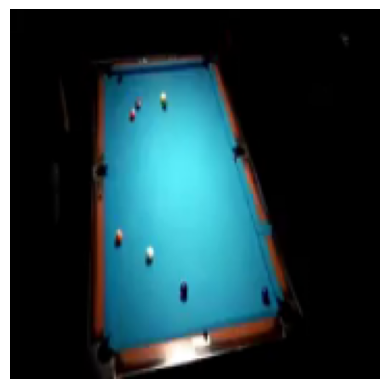

In [18]:
random_image_from_dataloader(train_data_single, train_dict) # Random image from the train dataset

Image tensor:
tensor([[[0.1294, 0.1098, 0.0902,  ..., 1.0000, 1.0000, 1.0000],
         [0.1333, 0.1176, 0.1020,  ..., 1.0000, 1.0000, 1.0000],
         [0.1373, 0.1333, 0.1176,  ..., 1.0000, 1.0000, 0.9961],
         ...,
         [0.5059, 0.5098, 0.5176,  ..., 0.6000, 0.6000, 0.6000],
         [0.5098, 0.5098, 0.5176,  ..., 0.6000, 0.6000, 0.6000],
         [0.5098, 0.5098, 0.5176,  ..., 0.6000, 0.6000, 0.6000]],

        [[0.1333, 0.1176, 0.0980,  ..., 0.9961, 0.9961, 0.9961],
         [0.1373, 0.1216, 0.1098,  ..., 0.9882, 0.9922, 0.9922],
         [0.1451, 0.1412, 0.1255,  ..., 0.9804, 0.9804, 0.9804],
         ...,
         [0.5608, 0.5608, 0.5686,  ..., 0.6353, 0.6353, 0.6353],
         [0.5569, 0.5608, 0.5686,  ..., 0.6353, 0.6353, 0.6353],
         [0.5608, 0.5608, 0.5686,  ..., 0.6353, 0.6353, 0.6353]],

        [[0.0863, 0.0627, 0.0392,  ..., 1.0000, 1.0000, 1.0000],
         [0.0902, 0.0706, 0.0510,  ..., 1.0000, 1.0000, 1.0000],
         [0.0902, 0.0784, 0.0627,  ..., 1.00

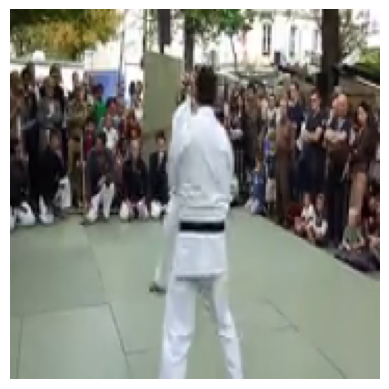

In [19]:
random_image_from_dataloader(test_data_single, test_dict) # Random image from the test dataset


### Turn loaded images into DataLoader's

In [20]:
# Turn train and test satasets into DataLoaders
BATCH_SIZE = 32 # <---------------------------- TODO: tune this paramenter
NUM_WORKERS = os.cpu_count()

In [21]:
'''
PORPOUSE: generate the train vaiadtion and test dataloaders

TAKES:
  - train_data: train dataset
  - val_data: validation dataset
  - test_data: test dataset
  - batch_size: specify how many bags of shots a bach must have
  - num_workers: specify how many workers will work on the dataloaders creation 

RETURNS: train, val and test dataloaders
'''

def generate_dataloaders(train_data, val_data, test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):

    train_dl = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
    val_dl = DataLoader(dataset = val_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
    test_dl = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)

    return train_dl, val_dl, test_dl

## Models definitions

In [22]:
# Defining the main custom Alexnet that ereditate the fucntion of nn.Module

class AlexNet(nn.Module):
    def __init__(self, in_channels, stream_type=None, t_frames=[1,1,1]):
        # stream_type: none, "context", "fovea"
        # None is used for considering the cnn with spartial fusion informations
        super().__init__()

        # input size nomultiresulution : (b x 3 x 170 x 170)
        # input size multiresulution : (b x 3 x 178 x 178) take into account the video classifier -> which becomes 89 x 89 in both streams

        self.stream_type = stream_type
        self.fovea = transforms.Compose([transforms.CenterCrop((89, 89))])
        self.context = transforms.Compose([transforms.Resize((89, 89))])
        self.transform = transforms.Compose([transforms.Resize((170, 170))])
        self.t_frames = t_frames

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels*self.t_frames[0], 96, kernel_size=11, stride=3, padding=2),  
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 170 x 170) -> (b x 96 x 55 x 55)
            # MULTIRES -> in: (b x 96 x 89 x 89) -> (b x 96 x 28 x 28)
            nn.ReLU(inplace=True),

            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 55 x 55) -> (b x 96 x 28 x 28)
            # MULTIRES -> in: (b x 96 x 28 x 28) -> (b x 96 x 14 x 14)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(96*self.t_frames[1], 256, kernel_size=5, stride=1, padding=2), 
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 28 x 28) -> (b x 256 x 28 x 28)
            # MULTIRES -> in: (b x 96 x 14 x 14) -> (b x 256 x 14 x 14)
            nn.ReLU(inplace=True),

            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # CORRECT
            # NO-MULTIRES -> in: (b x 256 x 28 x 28) -> (b x 256 x 14 x 14)
            # MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 256 x 7 x 7)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256*self.t_frames[2], 384, kernel_size=3, stride=1, padding=1), 
            # CORRECT
            # NO-MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 384 x 14 x 14)
            # MULTIRES -> in: (b x 256 x 7 x 7) -> (b x 384 x 7 x 7)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # CORRECT
            # NO-MULTIRES -> in: (b x 384 x 14 x 14) -> (b x 384 x 14 x 14)
            # MULTIRES -> in: (b x 384 x 7 x 7) -> (b x 384 x 7 x 7)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            # CORRECT
            # NO-MULTIRES -> in: (b x 384 x 14 x 14) -> (b x 256 x 14 x 14)
            # MULTIRES -> in: (b x 384 x 7 x 7) -> (b x 256 x 7 x 7)
            nn.ReLU(inplace=True)
        )

        self.MaxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # CORRECT
        # NO-MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 256 x 7 x 7)

        self.init_bias()  # initialize bias -> CHECK IF IT MAKE SENSE

    def init_bias(self):
        for block in [self.conv1, self.conv2, self.conv3]:
            for layer in block:
                if isinstance(layer, nn.Conv2d):
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                    nn.init.constant_(layer.bias, 0)
        # original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv2[0].bias, 1)
        nn.init.constant_(self.conv3[2].bias, 1)
        nn.init.constant_(self.conv3[4].bias, 1)


    def forward(self, x):
        if self.stream_type != None:
            x = self.fovea(x) if self.stream_type == 'fovea' else self.context(x)
            return self.conv3(self.conv2(self.conv1(x)))
        else: 
            x = self.transform(x)
            return self.MaxPool(self.conv3(self.conv2(self.conv1(x))))

### Single frame CNNs:
1. Single-Fame (custom AlexNet)
2. Single-Fame Fovea Only
3. Single-Fame Context Only
4. Single-Fame + Multires



In [23]:
# The single frame CNN, includes the three CNNs from the above list

class SingleResCNN(nn.Module):
    def __init__(self, CNN, num_classes):
        super(SingleResCNN, self).__init__()
        self.CNN = CNN

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        
    def forward(self, x):
        x = self.CNN(x)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [24]:
# Defining the single frame multiresolution CNN 

class MultiResCNN(nn.Module):
    def __init__(self, AlexNet_fovea, AlexNet_context, num_classes):
        super(MultiResCNN, self).__init__()
        self.AlexNet_fovea = AlexNet_fovea
        self.AlexNet_context = AlexNet_context

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096), # 512 since it takes the double of the infrormations
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        x1 = self.AlexNet_fovea(x.clone()) # Takes the fovea strea
        x2 = self.AlexNet_context(x.clone()) # Takes the contxt stream
        x = torch.cat((x1, x2), dim=1)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

### Multi Frames CNNs
1. Late Fusion
2. Early Fusion
3. Slow Fusion

In [25]:
# Late Fusion Model

class LateFusionCNN(nn.Module):
    def __init__(self, AlexNet_1, AlexNet_2, num_classes):
        super(LateFusionCNN, self).__init__()
        self.AlexNet_1 = AlexNet_1 # Two Separates AlexNet
        self.AlexNet_2 = AlexNet_2

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096),  # 512 since it takes the double of the infrormations
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        initial = torch.empty(x.shape[0], 3, 178, 178).to(device)
        final = torch.empty(x.shape[0], 3, 178, 178).to(device)
        
        for i in range(x.shape[0]):
            initial[i] = x[i][0]
            final[i] = x[i][1]

        initial = self.AlexNet_1(initial)
        final = self.AlexNet_2(final)
        x = torch.cat((initial, final), dim=1)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [26]:
# Early Fusion Model

class EarlyFusionCNN(nn.Module):
    def __init__(self, AlexNet, num_classes):
        super(EarlyFusionCNN, self).__init__()
        self.AlexNet = AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1]*3, 178, 178)
        x = self.AlexNet(x)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [27]:
# Sow Fusion Model

class SlowFusionCNN(nn.Module):
    def __init__(self, AlexNet, num_classes):
        super(SlowFusionCNN, self).__init__()
        self.AlexNet = AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        bag = torch.empty(4,x.shape[0],3*self.AlexNet.t_frames[0],178,178).to(device)
        
        for idx in range(bag.shape[0]): # 0 - 4
            for i in range(x.shape[0]): # 0 - batch_size
                bag[idx][i] = x[i][(idx) : (idx+4)].reshape(3*self.AlexNet.t_frames[0],178,178)

        rconv2_2 = torch.cat((self.AlexNet.conv2( # Second layer
            torch.cat((self.AlexNet.conv1(bag[0]), self.AlexNet.conv1(bag[1])), dim=1) # First layer
        ), self.AlexNet.conv2( # Second layer
            torch.cat((self.AlexNet.conv1(bag[2]), self.AlexNet.conv1(bag[3])), dim=1) # First layer
        )), dim=1)

        x = self.AlexNet.MaxPool(self.AlexNet.conv3(rconv2_2)) # Third layer

        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

### Train and Evaluate Architecture

In [28]:
# CNN Architecture to perform the Train and Evaluation steps saving the results

class CNN_Architecture():

  def __init__(self, model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
      val_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
      loss_fn: torch.nn.Module, score_fn, scheduler: torch.optim.Optimizer, device: torch.device, save_check = False):

      self.model = model.to(device)
      self.optimizer = optimizer
      self.train_dataloader = train_dataloader
      self.loss_fn = loss_fn
      self.val_dataloader = val_dataloader
      self.score_fn = score_fn
      self.scheduler = scheduler
      self.device = device
      self.save_check = save_check


  '''
  PORPOUSE: save the a checkpoint model

  TAKES:
    - train_loss: actual train loss
    - train_f1: actual train f1 score
    - epoch

  RETURNS: None
  '''
  def __save_checkpoint(self, train_loss, train_f1, epoch):
      #data_path = Path('data/')
      filename = f'/content/drive/MyDrive/checkpoints/{self.model.typ}_checkpoint.pth.tar'
      print('=> Saving Checkpoint')
      checkpoint = {'state_dict': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'scheduler': self.scheduler.state_dict(),
                    'train_loss': train_loss, 'train_f1': train_f1, 'epoch': epoch}
      torch.save(checkpoint, filename)
      print(' DONE\n')


  '''
  PORPOUSE: Load a chekpoint

  TAKES:
    - checkpoint: checkpoint to load

  RETURNS: None
  '''
  def __load_checkpoint(self,checkpoint):
      print('=> Loading Checkpoint')
      self.model.load_state_dict(checkpoint['state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer'])
      self.scheduler.load_state_dict(checkpoint['scheduler'])
      print(' DONE\n')
  

  '''
  PORPOUSE: Perform the model evaluation / testing

  TAKES:
    - val_dataloader: checkpoint to load
    - epoch / epochs

  RETURNS: dictionary containing the model name, loss and socore
  '''
  def evaluate(self, val_dataloader: torch.utils.data.DataLoader, epoch = 0, epochs = 1):
      val_loss, val_f1 = 0, 0

      self.model.eval() # Evaluation phase

      pbar = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave=False) # Initialize the progress bar

      with torch.inference_mode(): # Allow inference mode
          for batch_idx, (images, labels, _) in pbar:
              images, labels = images.to(self.device), labels.to(self.device) # Move the images and labels into the device

              outputs = self.model(images) # Get the model output

              loss = self.loss_fn(outputs, labels) # Get the loss

              f1 = self.score_fn(outputs, labels).item() # Perform the score

              # Increment the statistics
              val_loss += loss.item()
              val_f1 += f1

              # Update the progress bar
              if epoch > 0: pbar.set_description(f'{self.model.__class__.__name__} EVALUATION Epoch [{epoch + 1} / {epochs}]')
              else: pbar.set_description(f'{self.model.__class__.__name__} TESTING')
              pbar.set_postfix(loss = loss.item(), f1 = f1)
            
          val_loss /= len(val_dataloader) # Calculate the final loss
          val_f1 /= len(val_dataloader) # Calculate the final score

      model_name = self.model.__class__.__name__
      if self.model.__class__.__name__ == 'SingleResCNN': model_name = f'{model_name} - Stream Type: {self.model.CNN.stream_type}'

      return { 'model_name': model_name,
              'model_loss': val_loss,
              'model_f1': val_f1 }


  '''
  PORPOUSE: Perform the model traing

  TAKES:
    - epochs: number of times that our model will see the data

  RETURNS: dictionary of results containing model name and history of results for each epoch
  '''
  def fit(self, epochs: int):
      results = { 'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': [] }
      best_train_loss, best_train_f1 = float('inf'), float('-inf')

      for epoch in range(epochs):
          train_loss, train_f1 = 0, 0

          pbar = tqdm(enumerate(self.train_dataloader), total = len(self.train_dataloader), leave=False) # Initialize the progress bar
          
          for batch_idx, (images, labels, _) in pbar:

              self.model.train() # Training phase

              # zero_grad -> backword -> step

              self.optimizer.zero_grad()
              images, labels = images.to(self.device), labels.to(self.device) # Move the images and labels into the device
              
              outputs = self.model(images) # Get the model output

              loss = self.loss_fn(outputs, labels) # Get the loss

              loss.backward() # Backword step
              self.optimizer.step()

              train_loss += loss.item()
              f1 = self.score_fn(outputs, labels).item() # Perform the score

              train_f1 += f1

              model_name = self.model.__class__.__name__
              if self.model.__class__.__name__ == 'SingleResCNN': model_name = f'{model_name} - Stream Type: {self.model.CNN.stream_type}'

              # Update the progress bar
              pbar.set_description(f'{model_name} TRAIN Epoch [{epoch + 1} / {epochs}]')
              pbar.set_postfix(loss = loss.item(), f1 = f1)


          train_loss /= len(self.train_dataloader) # Calculate the final loss
          train_f1 /= len(self.train_dataloader) # Calculate the final score


          self.scheduler.step(train_loss)

          if(self.save_check): # Save a checkpoint if the actual results are the best one 
              if(train_loss < best_train_loss and train_f1 > best_train_f1):
                  self.__save_checkpoint(train_loss, train_f1, epoch + 1)
                  best_train_loss, best_train_f1 = train_loss, train_f1

          # Validation phase
          model_name, val_loss, val_f1 = (self.evaluate(self.val_dataloader, epoch, epochs)).values()

          # Append the results of the current epoch
          results['train_loss'].append(train_loss)
          results['train_f1'].append(train_f1)
          results['val_loss'].append(val_loss)
          results['val_f1'].append(val_f1)

          print('Epoch [{}], train_loss: {:.6f}, train_f1: {:.6f}, val_loss: {:.6f}, val_f1: {:.6f} \n'.format(
                epoch + 1, train_loss, train_f1, val_loss, val_f1))

      return {'model_name': model_name, 'results': results}

  
  '''
  PORPOUSE: Perform the evaluation of an image and plot it

  TAKES:
    - image_tensor: tensor representing the image 
    - class_names: labels name of our image
    - transform
    - mean
    - std

  RETURNS: None
  '''
  def evaluate_and_plot_image(self, images_tensor, class_names, transform=None, mean=[0.4588,0.4588,0.4588], std=[0.4588,0.4588,0.4588]):
      topk = 3 # Number of top k labels that we want to see

      if transform is not None: image_transform = transform
      else: image_transform = transforms.Compose([ transforms.Normalize(mean=mean, std=std) ])
      
      self.model.to(self.device) # Move the model to device

      self.model.eval() # Evauation phase
      
      with torch.inference_mode(): # Allow inference mode
          transformed_image = image_transform(images_tensor).unsqueeze(dim=0)
          targets_image_pred = self.model(transformed_image.to(self.device)) # Get the model output

      target_image_pred_probs = torch.sigmoid(targets_image_pred).to('cpu')
      top_k_probs_labels = torch.topk(target_image_pred_probs, k=topk, dim=1) # Get the probability of the top K labels

      label_pred_names = [LABELS[int(lab.numpy())]for lab in top_k_probs_labels.indices[0]] # Get the name of the top K labels


      # Images plot

      if(len(images_tensor.shape) == 3):
          plt.figure(figsize=(5,5))
          plt.title(f"Model: {self.model.__class__.__name__}")
          plt.imshow(images_tensor.permute(1, 2, 0).numpy())
          plt.axis(False)
      else:
          ids_frames = []
          if images_tensor.shape[0] == 2: ids_frames = [1, -1]
          elif images_tensor.shape[0] == 5: ids_frames = np.arange(5).tolist()
          else: ids_frames = np.arange(10).tolist()

          tb = widgets.TabBar([f'Frame {str(i)}' for i in ids_frames])

          for img in range(0, images_tensor.shape[0]):
              with tb.output_to(img, select=(img == 0)):
                plt.imshow(images_tensor[img].permute(1, 2, 0).numpy())
                plt.axis(False)
                plt.title(f"Model: {self.model.__class__.__name__} - Frame: {ids_frames[img]}")
                
      print(f'True Labels:\t{class_names}\nTop {topk} Pred:\t{label_pred_names}\nTop {topk} Prob:\t{top_k_probs_labels.values[0].numpy().tolist()}')

In [29]:
'''
PORPOUSE: Perform MultilabelF1Score

TAKES:
  - outputs: model output
  - labels: ground truth

RETURNS: MultilabelF1Score
'''

def f1_score(outputs, labels):
    metric = MultilabelF1Score(num_labels=len(LABELS)).to(device)
    return metric(outputs, labels)
    # seems reasonable, for me not at all, always 0.00205!!!!!!!!!!!!!!!!!!!!

# Let's run all!

In [30]:
NUM_EPOCHS = 100 #20
n_classes = len(LABELS)

In [31]:
'''
PORPOUSE: Plot Loss and Score curves

TAKES:
  - results_info: dictionary containing the results and model name

RETURNS: None
'''

def plot_loss_curves(results_info):
    res = results_info['results']
    epochs = range(len(res['train_loss']))

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))

    plt.title(results_info['model_name'])

    ax[0].plot(epochs, res['train_loss'], label = 'train_loss')
    ax[0].plot(epochs, res['val_loss'], label = 'val_loss')
    ax[0].set_title('Loss - Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(epochs, res['train_f1'], label = 'train_f1_score')
    ax[1].plot(epochs, res['val_f1'], label = 'val_f1_score')
    ax[1].set_title('F1 Score - Epochs')
    ax[1].set_ylabel('F1 Score')
    ax[1].set_xlabel('Epochs')
    ax[1].grid()
    ax[1].legend();

In [32]:
'''
PORPOUSE: Perform the training and evaluation plotting the results

TAKES:
  - model: CNN model to use
  - test: test dataloader
  - EPOCHS: numer of times that our model will see the data

RETURNS: Train history and results from test evaluation
'''

def train_evaluate(model, test, epochs=NUM_EPOCHS):
    start_time = timer()
    history = model.fit(NUM_EPOCHS)  # Train the model, it returns {'model_name': model_name, 'results': results}
    end_time = timer()

    print(f'Total training time: {end_time-start_time:.3f} seconds')

    plot_loss_curves(history) # Compare the results between train and validation set

    start_time = timer()
    result = model.evaluate(test) # Evaluate the model in the Tran dataloader
    # It returns {'model_name': model_name, 'model_loss': val_loss.item(), 'model_f1': val_f1.item()}
    end_time = timer()


    print(f'Total evaluation time: {end_time-start_time:.3f} seconds\n')
    print(f"TEST Results for {result['model_name']} -> loss: {result['model_loss']} f1-score: {result['model_f1']}")
    
    return (history, result)

In [33]:
'''
PORPOUSE: Perform the evaluation given a single image

TAKES:
  - dl: image dataloader
  - dic: image dictionary
  - cnn_arc: CNN model

RETURNS: None 
'''

def test_single_image(dl, dic, cnn_arc):
    rnd = random.choice(dl)
    img, label, path = rnd
    label_ids, label_names = get_label_ids_names(dic, path)
    cnn_arc.evaluate_and_plot_image(img, label_names)

In [35]:
'''
PORPOUSE: Calculate the class weights since we have an imbalance dataset

TAKES:
  - train_ds: train dataframe
  - test_ds: test dataframe
  - n_classes: number of classes

RETURNS: np.array of weights
'''

def calculate_pos_weights(train_df, test_df, n_classes):
    col = list(map(str, range(n_classes)))

    count_train = train_df[col].sum(axis=0).to_numpy()
    count_test = test_df[col].sum(axis=0).to_numpy()
    class_counts = count_train + count_test

    l = len(train_df) + len(test_df)

    pos_weights = np.ones_like(class_counts)
    neg_counts = [l - pos_count for pos_count in class_counts]


    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts.tolist(),  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5) # asserts also division by zero since we add 1e-5

    return torch.as_tensor(pos_weights, dtype=torch.float).to(device)

weights = calculate_pos_weights(train_df, test_df, n_classes)
weights

tensor([7.0900e+02, 1.4350e+03, 3.6500e+02, 1.7300e+02, 2.5600e+02, 5.8900e+02,
        2.5600e+02, 3.6100e+02, 7.2900e+02, 1.3740e+03, 4.3800e+02, 1.0500e+03,
        1.1740e+03, 3.0600e+02, 3.3600e+02, 4.6400e+02, 2.9700e+02, 4.5500e+02,
        4.5200e+02, 7.4100e+02, 1.5560e+03, 7.8200e+02, 1.4900e+02, 3.8100e+02,
        3.2300e+02, 5.4400e+02, 1.2540e+03, 6.7200e+02, 4.0000e+02, 6.0800e+02,
        2.8500e+02, 9.9300e+02, 1.0580e+03, 1.1030e+03, 8.1700e+02, 6.7200e+02,
        4.9200e+02, 4.4900e+02, 5.6300e+02, 5.2400e+02, 1.1960e+03, 8.3300e+02,
        1.0850e+03, 2.2270e+03, 7.6800e+02, 1.5750e+03, 7.2100e+02, 4.8800e+02,
        6.5800e+02, 9.3500e+02, 5.8600e+02, 1.1030e+03, 3.7900e+02, 4.1000e+02,
        6.9000e+02, 5.4200e+02, 5.9700e+02, 1.5100e+02, 4.6500e+02, 5.0700e+02,
        4.6700e+02, 5.1200e+02, 4.8600e+02, 5.8100e+02, 7.2100e+02, 9.2200e+02,
        5.8900e+02, 6.1400e+02, 5.2800e+02, 4.1600e+02, 9.2200e+02, 1.6140e+03,
        7.9700e+02, 4.7000e+02, 3.6700e+

Dataloaders definitons

In [36]:
train_dl_single, val_dl_single, test_dl_single = generate_dataloaders(train_data_single, val_data_single, test_data_single)
train_dl_late, val_dl_late, test_dl_late = generate_dataloaders(train_data_late, val_data_late, test_data_late)
train_dl_early, val_dl_early, test_dl_early = generate_dataloaders(train_data_early, val_data_early, test_data_early)
train_dl_slow, val_dl_slow, test_dl_slow = generate_dataloaders(train_data_slow, val_data_slow, test_data_slow)

Defining the container of the experiments

In [37]:
experiments_results = []

## Single Frame Model CNN

In [38]:
AN_single = AlexNet(in_channels=3) # Extractor
Single_CNN = SingleResCNN(AN_single, num_classes=n_classes) # CNN model

optimizer_single = torch.optim.SGD(params=Single_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_single = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_single, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_single = CNN_Architecture(model = Single_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_single,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_single,
             device = device,
             save_check = True)

In [39]:
experiments_results.append(train_evaluate(CNN_arch_single, test_dl_single)) # Run train and evaluation

  0%|          | 0/2661 [00:00<?, ?it/s]

FileNotFoundError: ignored

In [ ]:
test_single_image(test_data_single, test_dict, CNN_arch_single) # Test in a single random image

## Single Frame Model Fovea CNN

In [ ]:
AN_Fovea = AlexNet(in_channels=3, stream_type='fovea') # Extractor
Fovea_CNN = SingleResCNN(AN_Fovea, num_classes=n_classes) # CNN model

optimizer_fovea = torch.optim.SGD(params=Fovea_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_fovea = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fovea, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_fovea = CNN_Architecture(model = Fovea_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_fovea,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_fovea,
             device = device,
             save_check = True)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_fovea, test_dl_single)) # Run train and evaluation

In [ ]:
test_single_image(test_data_single, test_dict, CNN_arch_fovea) # Test in a single random image

## Single Frame Model Context CNN

In [ ]:
AN_Context = AlexNet(in_channels=3, stream_type='context') # Extractor
Context_CNN = SingleResCNN(AN_Context, num_classes=n_classes) # CNN model

optimizer_context = torch.optim.SGD(params=Context_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_context = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_context, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_context = CNN_Architecture(model = Context_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_context,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_context,
             device = device,
             save_check = True)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_context, test_dl_single)) # Run train and evaluation

In [ ]:
test_single_image(test_data_single, test_dict, CNN_arch_context) # Test in a single random image

## Single Frame Model Multiresolution CNN

In [ ]:
AN_Multi_Fovea, AN_Multi_context = AlexNet(in_channels=3, stream_type='fovea'), AlexNet(in_channels=3, stream_type='context') # Extractors
Multi_CNN = MultiResCNN(AN_Multi_Fovea, AN_Multi_context, num_classes=n_classes) # CNN model

optimizer_multi = torch.optim.SGD(params=Multi_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_multi = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_multi, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_multi = CNN_Architecture(model = Multi_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_multi,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_multi,
             device = device,
             save_check = True)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_multi, test_dl_single)) # Run train and evaluation

In [ ]:
test_single_image(test_data_single, test_dict, CNN_arch_multi) # Test in a single random image

## Multi Frame Model Late Fusion CNN

In [ ]:
AN_Late1, AN_late2 = AlexNet(in_channels=3), AlexNet(in_channels=3) # Extractors
Late_CNN = LateFusionCNN(AN_Late1, AN_late2, num_classes=n_classes) # CNN model

optimizer_late = torch.optim.SGD(params=Late_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_late = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_late, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_late = CNN_Architecture(model = Late_CNN, 
             train_dataloader = train_dl_late,
             val_dataloader = val_dl_late,
             optimizer = optimizer_late,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_late,
             device = device,
             save_check = True)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_late, test_dl_late)) # Run train and evaluation

In [ ]:
test_single_image(test_data_late, test_dict, CNN_arch_late) # Test in a single random image

## Multi Frame Model Early Fusion CNN

In [ ]:
AN_Early = AlexNet(in_channels=3, t_frames=[5,1,1]) # Extractor
Early_CNN = EarlyFusionCNN(AN_Early, num_classes=n_classes) # CNN model

optimizer_early = torch.optim.SGD(params=Early_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_early = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_early, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_early = CNN_Architecture(model = Early_CNN, 
             train_dataloader = train_dl_early,
             val_dataloader = val_dl_early,
             optimizer = optimizer_early,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_early,
             device = device,
             save_check = True)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_early, test_dl_early)) # Run train and evaluation

In [ ]:
test_single_image(test_data_early, test_dict, CNN_arch_early) # Test in a single random image

## Multi Frame Model Slow Fusion CNN

In [ ]:
AN_Slow = AlexNet(in_channels=3, t_frames=[4,2,2]) # Extractor
Slow_CNN = SlowFusionCNN(AN_Slow, num_classes=n_classes) # CNN model

optimizer_slow = torch.optim.SGD(params=Slow_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_slow = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_slow, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_slow = CNN_Architecture(model = Slow_CNN, 
             train_dataloader = train_dl_slow,
             val_dataloader = val_dl_slow,
             optimizer = optimizer_slow,
             loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights),
             score_fn = f1_score,
             scheduler = scheduler_slow,
             device = device,
             save_check = True)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_slow, test_dl_slow)) # Run train and evaluation

In [ ]:
test_single_image(test_data_slow, test_dict, CNN_arch_slow) # Test in a single random image

## Result Summary

Summary Widget with all the previous loss & score plot

In [ ]:
tb = widgets.TabBar([exp[0]['model_name'] for exp in experiments_results])

for idx, exp in enumerate(experiments_results):
    history, _ = exp
    with tb.output_to(history['model_name'], select=(idx == 0)):
        plot_loss_curves(history)


Summary of test results

In [ ]:
test_results_grid = widgets.Grid(len(experiments_results) + 1, 3, header_row=True)

with test_results_grid.output_to(0, 0): print('Model Name')
with test_results_grid.output_to(0, 1): print('Loss')
with test_results_grid.output_to(0, 2): print('F1 Score')

for row, exp in enumerate(experiments_results):
    _, results = exp
    for col, val in enumerate(results.values()):
        with test_results_grid.output_to(row + 1, col): print(val)